# Problem HANGMAN

### Installing required packages

In [54]:
# !pip install nltk
# !pip install numpy
# !pip install pandas

In [2]:
import nltk

In [55]:
#nltk.download()

### Importing required packages

In [56]:
from nltk.corpus import wordnet
import os
import numpy as np
import pandas as pd

### Setting up directories and getting target words and Training Dataset

In [5]:

curr_dir = os.getcwd()
target_words_dir = 'Targets.txt'
target_txt = open(os.path.join(curr_dir,target_words_dir),"r")

def get_target_words(file_dir):
    target_txt = open(file_dir,"r")
    words = target_txt.readlines()
    return([word[:-1].lower() for word in words])

def get_dataframe(target_words):
    data = {"words":[],"description":[]}
    for word in target_words:
        try:
            synset = wordnet.synsets(word)         
            data["description"].append(synset[0].definition())
            data["words"].append(word)
        except:pass
    return pd.DataFrame(data)

In [6]:
target_words = np.array(get_target_words(target_words_dir))
data = get_dataframe(target_words)

In [57]:
data.head(4)

,Masked,preds,description
0,e x _ m p _ a _,exemplar,something to be imitated
1,g _ m,gam,a herd of whales


In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords  
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional 
#from tensorflow.keras.callbacks import EarlyStopping

## Preprocessing Data

In [59]:
class PreProcess:
    tokenizer = Tokenizer(oov_token="<OOV>")
    max_sequence_len = None
    def __init__(self,corpus):
        self.corpus = self.remove_stop_words(corpus)
        self.tokenizer.fit_on_texts(corpus)
        
    def remove_stop_words(self,data):
        stop_words = set(stopwords.words('english'))
        for i in range(len(data)):
            sent_lst = list(data[i].split(" "))
            sent_lst = filter(lambda x: x not in stop_words, sent_lst)
            data[i] = ' '.join([str(wrd) for wrd in sent_lst])
        return data
            
    def tokenize(self,data):
        data = self.remove_stop_words(data)
        seq = self.tokenizer.texts_to_sequences(data)
        if(self.max_sequence_len == None):self.max_sequence_len = max([len(x) for x in seq])        
        seq_padded = pad_sequences(seq,maxlen=self.max_sequence_len)
        return(seq_padded)
    
    def get_word_index(self):
        return(self.tokenizer.word_index)
    
    def get_seq_length(self):
        return self.max_sequence_len
    
    def get_vocab_length(self):
        return len(self.tokenizer.word_index) + 1
    

## Preprocessing Meaning of the words

In [60]:
pre_pro_X = PreProcess(data['description'])
X = np.array(pre_pro_X.tokenize(data['description']))

max_seq_length = pre_pro_X.get_seq_length()
vocab_length = pre_pro_X.get_vocab_length()
#print(max_seq_length)

## Preprocessing the Labels

In [61]:
pre_pro_y = PreProcess(data['words'])
y = np.array(pre_pro_y.tokenize(data['words']))

total_target_words = pre_pro_y.get_vocab_length()
ys = tf.keras.utils.to_categorical(y, num_classes=total_target_words)


KeyError: 'words'

## Model 

In [62]:
model = Sequential()

model.add(Embedding(vocab_length, 100, input_length=36))

model.add(Bidirectional(LSTM(256)))

model.add(Bidirectional(LSTM(128)))

model.add(Dense(total_target_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="ADAM",metrics=['accuracy'])

In [63]:
earlystop = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X, ys, epochs=20, verbose=1,callbacks=[earlystop])

ValueError: Data cardinality is ambiguous:
  x sizes: 2
  y sizes: 21477
Please provide data which shares the same first dimension.

In [69]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 100)           600       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_1 (Dense)              (None, 32498)             16671474  
Total params: 17,403,210
Trainable params: 17,403,210
Non-trainable params: 0
_________________________________________________________________
None


## Saving the Model

## Loading the Model

## Model Evaluation

In [64]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

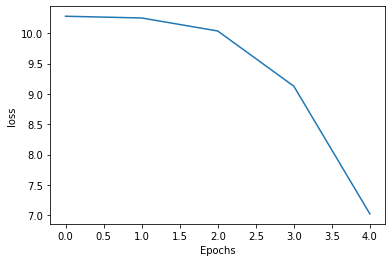

In [17]:
plot_graphs(history, 'loss')

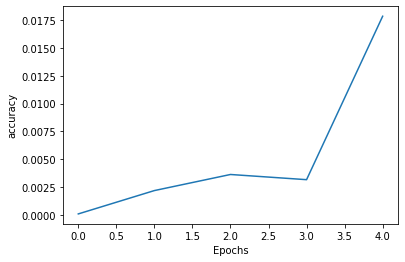

In [65]:
plot_graphs(history,'accuracy')

## Predicting for Test Data

In [51]:
class Predict:
    
    def __init__(self,target_words,model,pre_pro_X,pre_pro_y):
        self.target_words =  target_words
        self.model        =  model
        self.pre_pro_X    =  pre_pro_X
        self.pre_pro_y    =  pre_pro_y
        
    def get_words_set(self,pred_word,dashed,wrd_len):
        words_set = filter(lambda word : nltk.edit_distance(word, pred_word) ==  dashed and wrd_len ==  len(word),
                          self.target_words)
        return words_set
        
    def predict_word(self,wrd,preds):
        wrd_lst = wrd.split(" ")
        wrd_conv = ''.join(x for x in filter(lambda x: x!='_', wrd_lst))
        
        words_set = self.get_words_set(wrd_conv,wrd_lst.count('_'),len(wrd_lst))
        
        target_wrds_set = list(self.pre_pro_y.tokenizer.word_index.keys())
        target_wrds_inxs, selective_preds = [],[]

        for word in words_set:
            try:target_wrds_inxs.append(word)
            except:pass    

        for inx in target_wrds_inxs:
            try:selective_preds.append(preds[target_wrds_set.index(inx)])
            except:pass

        max_prob = max(selective_preds)
        return(target_wrds_set[preds.index(max_prob)])
                
    
    def predict_words(self,words_dataframe):
        final_preds = {"Masked":[],"preds":[],"description":[]}
        
        for index,row in words_dataframe.iterrows():
            final_preds["Masked"].append(row["Masked"])
            final_preds["description"].append(row["Meaning"])
            
            test_desc_encoded = self.pre_pro_X.tokenize([row['Meaning']])
            preds = list(self.model.predict(test_desc_encoded).reshape(-1))
            
            final_preds["preds"].append(self.predict_word(row["Masked"],preds))
        
        return final_preds
                   

                
predict = Predict(target_words, model, pre_pro_X, pre_pro_y)
df = pd.DataFrame({"Masked":['e x _ m p _ a _','g _ m'],"Meaning":["something to be imitated","a herd of whales"]})
print(predict.predict_words(df))
                


{'Masked': ['e x _ m p _ a _', 'g _ m'], 'preds': ['exemplar', 'gam'], 'description': ['something to be imitated', 'a herd of whales']}


In [66]:
data =pd.DataFrame(predict.predict_words(df))

In [68]:
print(data.head(2))

            Masked     preds               description
0  e x _ m p _ a _  exemplar  something to be imitated
1            g _ m       gam          a herd of whales
